In [1]:
from domoku.board import GomokuBoard
from domoku.minimax import MinimaxSearch
from domoku.policies.softadvice import MaxInfluencePolicyParams, MaxInfluencePolicy
from domoku.policies.maximal_criticality import MaxCriticalityPolicy
from domoku.ddpg import NxNx4Game, Trainer, DdpgPlayer
from domoku import data
from domoku.tools import GomokuTools as gt
from domoku.constants import *

---

# Heuristic = Soft Policy and Criticallity Model

In [2]:
SIZE=15

hard_policy = MaxCriticalityPolicy(SIZE, overconfidence=1)

params = MaxInfluencePolicyParams(
    n=SIZE,
    sigma=.7,
    iota=3,
    radial_constr = [.0625, .125, .25, .5],
    radial_obstr = [-.0625, -.125, -.25, -.5]
)

initial_state = data.create_nxnx4(size=15, stones=[('H', 8)])
white = MaxInfluencePolicy(params, pov=WHITE, criticality_model=hard_policy)
black = MaxInfluencePolicy(params, pov=BLACK, criticality_model=hard_policy)

2022-05-21 16:10:19.722300: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# Creating Heuristic Trajectories en masse

In [3]:
NUM_TRAJECTORIES = 1
trainer = Trainer(SIZE, white)

found = False
trajectories = None
while not found:
    trajectories = trainer.create_trajectories(num_trajectories=NUM_TRAJECTORIES, max_length=80,
                                               initial_state=initial_state, terminal=True)
    found = trajectories != [None]

end_state = trajectories[0][-1][1]
gt.print_bin(end_state, True)

shape: (15, 15, 4)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 2. 2. 2. 2. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 2. 2. 2. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0. 1. 1. 2. 1. 0. 0.]
 [0. 0. 0. 0. 2. 1. 0. 1. 0. 1. 2. 2. 0. 0. 1.]
 [0. 0. 0. 0. 2. 1. 2. 2. 2. 1. 1. 2. 2. 2. 2.]
 [0. 0. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 2. 0. 0.]
 [0. 0. 0. 0. 2. 2. 0. 1. 0. 2. 0. 2. 2. 1. 0.]
 [0. 0. 0. 0. 0. 0. 2. 0. 2. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 2. 1. 1. 2. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 2. 0. 2. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 2. 1. 0. 0. 2. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 2. 0. 0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [4]:
rewind = 5

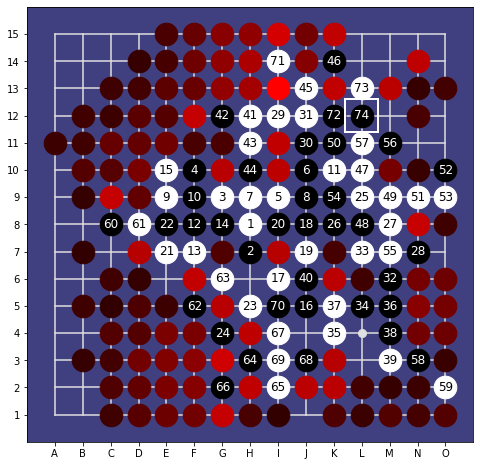

In [5]:
board = None
for i in range(NUM_TRAJECTORIES):
    if trajectories[i] is not None:
        moves = [gt.m2b(t[0], SIZE) for  t in trajectories[i][1:-rewind]]
        board = GomokuBoard(SIZE, heuristics=white, disp_width=8, stones=[('H', 8)] + moves)
board.display()

### Minimax, sometimes smart, sometimes not so well-advised by the heuristic policy

In [6]:
some_prev_state = trajectories[0][-rewind-1][1]

In [7]:
hard_policy = MaxCriticalityPolicy(SIZE, overconfidence=2)

params = MaxInfluencePolicyParams(
    n=SIZE,
    sigma=.7,
    iota=3,
    radial_constr = [.0625, .125, .25, .5],
    radial_obstr = [-.0625, -.125, -.25, -.5]
)
POV = 0
initial_state = some_prev_state
heuristics = MaxInfluencePolicy(params, pov=POV, criticality_model=hard_policy)
search = MinimaxSearch(NxNx4Game(initial_state), heuristics, 10, 6)
value, sequence = search.minimax(initial_state)

COLORS = ['BLACK', 'WHITE']
print(f"{COLORS[POV]} {'wins' if value == 1 else 'loses' if value == -1 else 'undecided'}")
game = NxNx4Game(initial_state)
[game.as_str(m) for m in sequence]

BLACK wins


['I13', 'I15', 'K13', 'H13', 'M13']

#  Observing 2 players with tree-search capabilities

This arrangement creates some very intriguing game plays, although no modern AI is on board, yet!

In [8]:
tight_params = MaxInfluencePolicyParams(
    n=SIZE,
    sigma=.3,
    iota=2,
    radial_constr = [.0625, .125, .25, .5],
    radial_obstr = [-.0625, -.125, -.25, -.5]
)
loose_params = MaxInfluencePolicyParams(
    n=SIZE,
    sigma=.7,
    iota=3,
    radial_constr = [.0625, .125, .25, .5],
    radial_obstr = [-.0625, -.125, -.25, -.5]
)

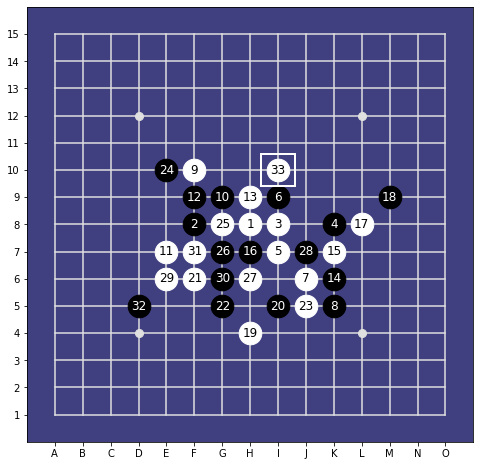

In [12]:
initial_state = data.create_nxnx4(size=15, stones=[('H', 8)])

heuristics_black = MaxInfluencePolicy(tight_params, pov=0, criticality_model=hard_policy)
black = DdpgPlayer(heuristics_black, tree_search=(4, 3))

heuristics_white = MaxInfluencePolicy(loose_params, pov=1, criticality_model=hard_policy)
white = DdpgPlayer(heuristics_white, tree_search=(4, 3))

trajectories = trainer.create_trajectories(black=black, white=white,
                                           num_trajectories=1, max_length=80,
                                           initial_state=initial_state, terminal=False)
moves = [p[0] for p in trajectories[0]]
stones = [('H', 8)] + [gt.m2b(m, 15) for m in moves[1:]]
GomokuBoard(15, disp_width=8, stones=stones).display()